$
\newcommand{\calf}{{\cal F}}
\newcommand{\dnu}{d \nu}
\newcommand{\mf}{{\bf F}}
\newcommand{\vu}{{\bf u}}
\newcommand{\vx}{{\bf x}}
\newcommand{\vy}{{\bf y}}
\newcommand{\vs}{{\bf s}}
\newcommand{\ve}{{\bf e}}
\newcommand{\vd}{{\bf d}}
\newcommand{\mg}{{\bf G}}
\newcommand{\ml}{{\bf L}}
\newcommand{\mg}{{\bf G}}
\newcommand{\mv}{{\bf V}}
\newcommand{\ma}{{\bf A}}
\newcommand{\mi}{{\bf I}}
\newcommand{\mm}{{\bf M}}
\newcommand{\ball}{{\cal B}}
\newcommand{\ptc}{{\Psi TC}}
\newcommand{\diag}{\mbox{diag}}
$

In [123]:
include("fanote_init.jl")

┌ Warning: /Users/ctk/Dropbox/Julia/dotdev/NotebookSIAMFANL/src/threewaystagnationv2.jl no longer exists, deleted all methods
└ @ Revise /Users/ctk/.julia/packages/Revise/qYvgD/src/packagedef.jl:634


## Section 1.10 Solvers for Chapter 1

Contents for Section 1.10

[Overview](#Overview)

[nsolsc.jl](#nsolsc.jl)

[ptcsolsc.jl](#ptcsolsc.jl)

[Section 1.11: Projects](#Section-1.11-Projects)


### Overview

We provide three solvers for this chapter. __nsolsc.jl__ is a scalar Newton code and __ptcsolsc.jl__ is a scalar pseudo-transient continuation solver. These scalar codes are simply wrappers for the general codes __nsol.jl__
and __ptcsol.jl__. We also include __secant.jl__, which is the secant method for scalar equations. 

Their calling sequences and the tuples they returns are very similar to all the codes from this book. All our solvers return a tuple with the solution, the history of the iteration, flags for success or failure, and (optionally) the entire history of the solution. 

We will continue
this pattern for the entire book, discussing theory and algorithms at the
beginning of each chapter together with a few examples. In the notebook
section we will cover the software in more detail and go deeper into
examples.

The solution history for scalar equations is small and returning it is the default. In the later chapters on systems of equations, we do not return the solution history by default and discourage your asking for it. The solution history might take a lot of space to store and also, especially in Julia, have a severe penalty for allocations.

### nsolsc.jl

__nsolsc.jl__ is the scalar Newton solver. We will begin, as we will in all the software sections, by looking at the documentation (docstrings) in the code.

In [124]:
? nsolsc

search: nsolsc



nsolsc(f,x0, fp=difffp; rtol=1.e-6, atol=1.e-12, maxit=10,         solver="newton", sham=1, armmax=10, resdec=.1, dx=1.e-7,         armfix=false,          printerr=true, keepsolhist=true, stagnationok=false)

C. T. Kelley, 2020

Newton's method for scalar equations. Has most of the features a code for systems of equations needs. This is a wrapper for a call to nsol.jl, the real code for systems. 

Input:

f: function

x0: initial iterate

fp: derivative. If your derivative function is fp, you give me its name. For example fp=foobar tells me that foobar is your function for the derivative. The default is a forward difference Jacobian that I provide.

Keyword Arguments (kwargs):

rtol, atol: real and absolute error tolerances

maxit: upper bound on number of nonlinear iterations

solver:

Your choices are "newton"(default) or "chord". However,  you have sham at your disposal only if you chose newton. "chord" will keep using the initial derivative until the iterate converges, uses the iteration budget, or the line search fails. It is not the same as sham=Inf, which is smarter.

If you use secant and your initial iterate is poor, you have made a mistake. I will help you by driving the line search with a finite difference derivative.

sham:

This is the Shamanskii method. If sham=1, you have Newton. The iteration updates the derivative every sham iterations. The convergence rate has local q-order sham+1 if you only count iterations where you update the derivative. You need not provide your own derivative function to use this option. sham=Inf is chord only if chord is converging well.

armmax: upper bound on stepsize reductions in linesearch

resdec: target value for residual reduction. 

The default value is .1. In the old MATLAB codes it was .5. I only turn Shamanskii on if the residuals are decreasing rapidly, at least a factor of resdec, and the line search is quiescent. If you want to eliminate resdec from the method ( you don't ) then set resdec = 1.0 and you will never hear from it again.  

dx:

This is the increment for forward difference, default = 1.e-7. dx should be roughly the square root of the noise in the function.

armfix:

The default is a parabolic line search (ie false). Set to true and the stepsize will be fixed at .5. Don't do this unless you are doing experiments for research.

printerr:

I print a helpful message when the solver fails. To supress that message set printerr to false.

keepsolhist:

Set this to true to get the history of the iteration in the output tuple. This is on by default for scalar equations and off for systems. Only turn it on if you have use for the data, which can get REALLY LARGE.

stagnationok:

Set this to true if you want to disable the line search and either observe divergence or stagnation. This is only useful for research or writing a book.

Output:

A named tuple (solution, functionval, history, stats, idid,                errcode, solhist) where

solution = converged result functionval = F(solution) history = the vector of residual norms (||F(x)||) for the iteration stats = named tuple of the history of (ifun, ijac, iarm), the number of functions/derivatives/steplength reductions at each iteration.

I do not count the function values for a finite-difference derivative because they count toward a Jacobian evaluation. I do count them for the secant method model.

idid=true if the iteration succeeded and false if not.

errcode = 0 if if the iteration succeeded         = -1 if the initial iterate satisifies the termination criteria         = 10 if no convergence after maxit iterations         = 1  if the line search failed

solhist:

This is the entire history of the iteration if you've set keepsolhist=true

nsolsc builds solhist with a function from the Tools directory. For systems, solhist is an N x K array where N is the length of x and K  is the number of iteration + 1. So, for scalar equations (N=1), solhist is a row vector. Hence the use of solhist' in the example below.

# Examples

```jldoctest
julia> nsolout=nsolsc(atan,1.0;maxit=5,atol=1.e-12,rtol=1.e-12);

julia> nsolout.history
6-element Array{Float64,1}:
 7.85398e-01
 5.18669e-01
 1.16332e-01
 1.06102e-03
 7.96200e-10
 2.79173e-24
```

# If you have an analytic derivative, I will use it.

```jldoctest
julia> fs(x)=x^2-4.0; fsp(x)=2x;

julia> nsolout=nsolsc(fs,1.0,fsp; maxit=5,atol=1.e-9,rtol=1.e-9);

julia> [nsolout.solhist'.-2 nsolout.history]
6×2 Array{Float64,2}:
 -1.00000e+00  3.00000e+00
  5.00000e-01  2.25000e+00
  5.00000e-02  2.02500e-01
  6.09756e-04  2.43940e-03
  9.29223e-08  3.71689e-07
  2.22045e-15  8.88178e-15

```


#### Input


Let's begin with the calling sequence for the solver.

```julia
nsolsc(
    f,
    x,
    fp = difffp;
    rtol = 1.e-6,
    atol = 1.e-12,
    maxit = 10,
    solver = "newton",
    sham = 1,
    armmax = 5,
    resdec = .1,
    armfix = false,
    keepsolhist = true,
)
```

The arguments before the semicolon are required except for the function that evaluates the derivative. If you leave it out, __nsolsc__ defaults to a forward difference approximation.
We are solving $f(x) = 0$ and the solver needs $f$ and the initial iterate $x$. The arguments after the semicolon are __keyword arguments__, usually referred to as __kwargs__, which is not a German cheese product. The semicolon is __very useful__. You may leave it out in recent versions of Julia, but it is good practice to leave it in
to remind yourself about which arguments are optional and which are not.
The good news about kwargs is that you may use any of them without worrying about the others, which will take their default values. So

```julia
nsolout0 = nsolsc(atan, 1.0)

nsolout1=nsolsc(atan, 3.0; sham=2, resdec=.5)
```
are all correct.


You have seen many of the kwargs before. The relative and absolute error tolerances, the solver, the parameters
for the Shamanskii method and line search should be familiar. The new things are __resedec__, __armfix__, and __keepsolshist__. For example, the derivative is updated every __sham__ iterations. The default for Newton's method is sham=1 for scalar equations. We do something else for systems and will explain that in [Chapter 2](SIAMFANLCh2.ipynb).


The default for derivative evaluation is a forward difference derivative. That is an internal function __difffp__.
If you have an analytic derivative, say __fpanal.jl__, then set fp=fpanal and the solver will use your derivative.

 We have mentioned the solution history before. Please leave __keepsolhist__ alone unless there's a good reason to change it. It is set to true for scalar codes and false for
the solvers in the following chapters.

__resdec__ is how we manage Shamanskii iterations. In this scalar code, it is used for some examples and to prepare you for its more serious use in the codes for systems of equations. In __nsolsc.jl__ the default solver is Newton's method (so sham=1). Newton with sham=2 is the Shamanskii method with a derivative update every two iterations. 
__But__ we safeguard the skipping of the update by doing the update anyhow if (1) the line search fails on the first attempt (ie with step length = 1) or (2) the residual decrease is more than __resdec__. If you want to eliminate the second of these, set resdec = 1. 

The only exception to the first criterion is the chord method. If you set```solver="chord"```then you will get chord. That's in there for research and a few internal tests of the code. 
If you set ```sham=Inf```, then you'll get the chord method with derivative updates when a step length of 1 fails to produce sufficient decrease or the reduction in residuals is not enough.

With the secant method, we compute the secant approximation to the derivative with every iteration. If the secant iterations are far apart, the approximation can be poor and the line search can fail. This is a risk you assume with all secant methods.


#### Output

The output of all the solvers is a tuple. This is a data structure in Julia that can pack different structures (including more tuples) in one thing. It's a good way to manage complex output.

Here is a simple example of how to use the output tuple. I'll find the root $x^*=0$ of $f(x) = tan^{-1}(x)$ and look at the iteration statistics.

In [125]:
tanout=nsolsc(atan,10.0)

(solution = -1.13371e-06, functionval = -1.13371e-06, history = [1.47113e+00, 1.19982e+00, 1.10593e+00, 6.48294e-01, 2.56979e-01, 1.19356e-02, 1.13371e-06], stats = (ifun = [1, 3, 2, 2, 1, 1, 1], ijac = [0, 1, 1, 1, 1, 1, 1], iarm = [0, 2, 1, 1, 0, 0, 0]), idid = true, errcode = 0, solhist = [1.00000e+01 2.57080e+00 … 1.19362e-02 -1.13371e-06])

As the problems become larger in the course of the book. I will start putting a semicolon after calls to the solvers to stop printing the output
after the call. This is exactly the same as the semicolon in Matlab.
I've taken the defaults for everything, so the iteration terminated when the residual was about $10^{-6}$. Note that the solution history is part of the output. You can (and should) turn this off for systems of equations where the solution history can become a massive storage burden. It may be useful if you want to visualize the history with a movie, but is rarely worth the trouble. The solution and final function values are ...

In [126]:
[tanout.solution tanout.functionval]

1×2 Array{Float64,2}:
 -1.13371e-06  -1.13371e-06

Looking at the iteration history can help you find errors or convince you that things are going well. For example, since $\tan'(0)=1$, we would
expect the solution and final function values to be same, and they are.
One simple thing we will do often is to plot a semilog graph of the residual history. If we are comparing methods, it is a good idea to plot $|f(x_n)|/|f(x_0)|$ to that all the plots will begin at the same point. Here is a simple version of that. I like to label things, so I did that too. Since I'll be publishing this as a print book, I'll make the curves black to save on publication costs.

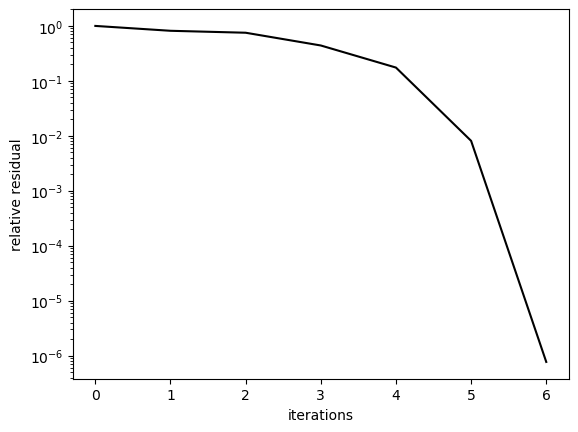

In [127]:
residdata=tanout.history./tanout.history[1]; sizehist=length(residdata)
semilogy(0:sizehist-1,residdata,"k-");
xlabel("iterations");
ylabel("relative residual");

PyPlot is very similar to plotting in Matlab, which is why I use it. The stats array has the data for function and derivative evaluations and the number of stepsize reductions in the line search. As you can see, the line search had some work to do in this example. If the iteration is not doing what you expect, a quick look at stats may help.

In [128]:
tanout.stats

(ifun = [1, 3, 2, 2, 1, 1, 1], ijac = [0, 1, 1, 1, 1, 1, 1], iarm = [0, 2, 1, 1, 0, 0, 0])

Here we see that the line search was active on iterations 1, 2, and 3 and every step size reduction costs a function evaluation like it's supposed to.

We will now looks at the docstrings for __secant.jl__. The interface is very similiar to __nsolsc.jl__. The only differences are that there is no reason to decide to reevaluate the derivative or not, since the secant method
computes the model derivative with every iteration, so kwargs like sham are missing. The output tuble is essentially the same as the other codes from this book.

In [129]:
?secant

search: secant



secant(f,x0; rtol=1.e-6, atol=1.e-12, maxit=10,         armmax=10, armfix=false,          printerr=true, keepsolhist=true, stagnationok=false)

C. T. Kelley, 2020

The secant method for scalar equations. Has most of the features a Broyden method code for systems of equations needs.

Input:

f: function

x0: initial iterate

Keyword Arguments (kwargs):

rtol, atol: real and absolute error tolerances

maxit: upper bound on number of nonlinear iterations

If you use secant and your initial iterate is poor, you have made a mistake. You will get an error message.

armmax: upper bound on stepsize reductions in linesearch

armfix:

The default is a parabolic line search (ie false). Set to true and the stepsize will be fixed at .5. Don't do this unless you are doing experiments for research.

printerr:

I print a helpful message when the solver fails. To supress that message set printerr to false.

keepsolhist:

Set this to true to get the history of the iteration in the output tuple. This is on by default for scalar equations and off for systems. Only turn it on if you have use for the data, which can get REALLY LARGE.

stagnationok:

Set this to true if you want to disable the line search and either observe divergence or stagnation. This is only useful for research or writing a book.

Output:

A named tuple (solution, functionval, history, stats, idid,                errcode, solhist) where

solution = converged result functionval = F(solution) history = the vector of residual norms (||F(x)||) for the iteration stats = named tuple of the history of (ifun, ijac, iarm), the number of functions/derivatives/steplength reductions at each iteration. For the secant method, ijac = 0.

idid=true if the iteration succeeded and false if not.

errcode = 0 if if the iteration succeeded         = -1 if the initial iterate satisifies the termination criteria         = 10 if no convergence after maxit iterations         = 1  if the line search failed

solhist:

This is the entire history of the iteration if you've set keepsolhist=true

secant builds solhist with a function from the Tools directory. For systems, solhist is an N x K array where N is the length of x and K  is the number of iteration + 1. So, for scalar equations (N=1), solhist is a row vector. Hence the use of solhist' in the example below.

# Examples

```jldoctest

julia> secout=secant(atan,1.0;maxit=6,atol=1.e-12,rtol=1.e-12);


julia> secout.history
7-element Array{Float64,1}:
 7.85398e-01
 5.18729e-01
 5.39030e-02
 4.86125e-03
 4.28860e-06
 3.37529e-11
 2.06924e-22
```


Now we can play with the options for __nsolsc.jl__ and __secant.jl__. Let's tighten the tolerances and compare three solvers. Newton's method and the secant method successfully found the solution. The chord method failed to converge and gave an error message.

In [130]:
tannewt=nsolsc(atan,1.0; rtol=1.e-12, atol=1.e-12);
tansec=secant(atan,1.0; rtol=1.e-12, atol=1.e-12);
tanchord=nsolsc(atan,1.0; rtol=1.e-12, atol=1.e-12, solver="chord");

Maximum iterations (maxit) of 10 exceeded
Convergence failure: residual norm too large  2.46512e-01
Try increasing maxit and checking your function and
            Jacobian for bugs.
Give the history array a look to see what's happening.
  


Let's examine the history array for the chord iteration.

In [131]:
tanchord.history

11-element Array{Float64,1}:
 7.85398e-01
 5.18669e-01
 4.36525e-01
 3.86104e-01
 3.50593e-01
 3.23686e-01
 3.02326e-01
 2.84806e-01
 2.70083e-01
 2.57474e-01
 2.46512e-01

Yes, that's going nowhere at all. The problem is that the derivative at $x_0 = 1$ is not good enough to make the chord iteration converge well. It would get there eventually, but only after far more iterations that you or I have the patience for. Let's plot the results and see what we got.

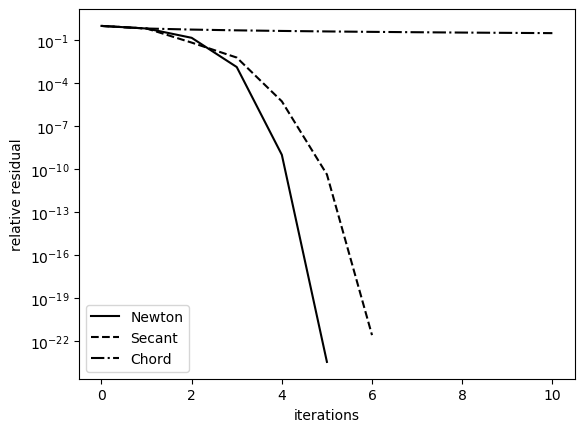

In [132]:
residdatan=tannewt.history./tannewt.history[1]; sizehistn=length(residdatan)
residdatas=tansec.history./tansec.history[1]; sizehists=length(residdatas)
residdatac=tanchord.history./tanchord.history[1]; sizehistc=length(residdatac)
semilogy(0:sizehistn-1,residdatan,"k-",
0:sizehists-1,residdatas,"k--",
0:sizehistc-1,residdatac,"k-."
);
legend(["Newton","Secant","Chord"]);
xlabel("iterations");
ylabel("relative residual");

This is exactly what you'd expect. The histories for the secant and Newton iterations have the downward concavity of superlinear convergence. Newton's method takes fewer nonlinear iterations (but only by one) while the secant method uses fewer calls to functions. Remember that Newton does a function and derivative evaluation at each step, while the secant iteration only needs a single function evaluation per step. 

We've seen how to run the solver, pick methods, and look at the output. We are almost done with this section and ready to move on to systems of equations in [Chapter 2](SIAMFANLCh2.ipynb). The last thing to do is talk about how to package your function. Suppose you have Julia code for your function (__myfun.jl__) and its derivative (__myfunp.jl__). Once in the REPL or a notebook, you can put these functions where Julia can find then with the __include__ command. You'd do

```Julia
include("myfun.jl")
include("myfunp.jl")
```
and then could invoke the solvers. This is far from ideal for many reasons.

Julia is a complied language. The code for your functions is complied when you invoke the __include__ command. If you make a change to __myfun.jl__, you would have to include it again before you could use it. 

Another way is to use a module to contain all the code you need for your function. __MyFunction.jl__ is an
example of such a module. If your function has many subfunctions and only a few of them are 
used outside of the function itself, putting them in a module is a very good
idea. That is why all of the examples in this book are in the 
__TestProblems__ submodule of SIAMFANLEquations.

```Julia
module MyFunction

export(myfun)
export(myfunp)

function myfun(x)
    fun=cos(x)-x
    return fun
end

function myfunp(x)
    funp=-sin(x)-1
    return funp
end
end
```

I've put __MyFunction.jl__ in the src/Chapter1 directory of NotebookSIAMFANL. You will be able to use it if you've run the ```include("fanote_init.jl")``` command in the first code cell. However, if it's your own module, you will need to make sure that it is in your __LOAD_PATH__ and then type a ```using command``` in the REPL. In this case that command would be


In [133]:
using NotebookSIAMFANL.MyFunction

To see if the functions are where they need to be, we'll evaluate them.

In [134]:
x=pi;
y=myfun(x);
yp=myfunp(x);
[y,yp]

2-element Array{Float64,1}:
 -4.14159e+00
 -1.00000e+00

We now have both __myfun__ and its derivative __myfunp__ ready to go. We will compare Newton's method with an analytic derivative to the iteration with a forward difference derivative (the default).

In [135]:
# Solve the equation twice.
# Once with a finite difference derivative ...
     myfunforwarddiff=nsolsc(myfun,1.0);
# and again with an analytic derivative.
     myfunanalytic=nsolsc(myfun,1.0,myfunp);
# Now subtract the residual histories.
     myfunforwarddiff.history-myfunanalytic.history

4-element Array{Float64,1}:
 0.00000e+00
 6.53120e-09
 4.36679e-10
 1.00131e-12

There's no significant difference. We will return to this in the subsequent chapters.

Finally we will see how we circumvented the normal termination criteria to generate __Figure 1.3__. The trick is to use the __stagnationok__ keyword. The call to Newton's method looked like

```Julia
nnout=nsolsc(ftanx,4.5; maxit=14, rtol=1.e-17, atol=1.e-17, printerr=false, stagnationok=true)

```
Setting __stagnationok = true__ turned off termination when the line search failed to obtain sufficient decrease, which would more sensible results. The purpose of this option is to do experiments and it's best left set to false (the default). A better version of __Figure 1.3__ would do this, but not show stagnation as vividly. __fig1dot3b.jl__ does that.

In [136]:
threewaystagnationv2();

LoadError: UndefVarError: threewaystagnationv2 not defined

### Pseudo-Transient Continuation
### ptcsolsc.jl

__ptcsolsc.jl__ is the scalar pseudo-transient continuation solver. As usual, we will start with the docstrings

In [137]:
?ptcsolsc

search: ptcsolsc ptcsol



ptcsolsc(f, x0, fp=difffp; rtol=1.e-6, atol=1.e-12, maxit=100,         dt0=1.e-6, dx=1.e-7, printerr = true, keepsolhist=true)

C. T. Kelley, 2020

Scalar pseudo-transient continuation solver. PTC is designed to find stable steady state solutions of 

dx/dt = - f(x)

The scalar code is a simple wrapper around a call to ptcsol.jl, the  PTC solver for systems.

–> PTC is ABSOLUTELY NOT a general purpose nonlinear solver.

Input:

f: function

x: initial iterate/data

fp: derivative. If your derivative function is fp, you give me its name. For example fp=foobar tells me that foobar is your function for the derivative. The default is a forward difference Jacobian that I provide.

Keyword Arguments:

rtol, atol: real and absolute error tolerances

maxit: upper bound on number of nonlinear iterations. This is  coupled to dt0. If your choice of dt0 is too small (conservative) then you'll need many iterations to converge and will need a larger value of maxit.

dt0: initial time step. The default value of 1.e-3 is a bit conservative  and is one option you really should play with. Look at the example where I set it to 1.0!

dx: default = 1.e-7

difference increment in finite-difference derivatives       h=dx*norm(x)+1.e-6

printerr: default = true

I print a helpful message when the solver fails. To supress that message set printerr to false.

keepsolhist: if true you get the history of the iteration in the output  tuple. This is on by default for scalar equations and off for systems. Only turn it on if you have use for the data, which can get REALLY LARGE.

Output: A tuple (solution, functionval, history, idid, errcode, solhist) where history is the array of absolute function values |f(x)| of residual norms and time steps. Unless something has gone badly wrong, dt approx |f(x_0)|/|f(x)|.

idid=true if the iteration succeeded and false if not.

errcode = 0 if if the iteration succeeded         = -1 if the initial iterate satisifies the termination criteria         = 10 if no convergence after maxit iterations

solhist=entire history of the iteration if keepsolhist=true

ptcsolsc builds solhist with a function from the Tools directory. For systems, solhist is an N x K array where N is the length of x and K  is the number of iteration + 1. So, for scalar equations (N=1), solhist is a row vector. Hence I use [ptcout.solhist' ptcout.history] in the example below.

If the iteration fails it's time to play with the tolerances, dt0, and maxit. You are certain to fail if there is no stable solution to the equation.

# Examples

```jldoctest
julia> ptcout=ptcsolsc(sptest,.2;dt0=2.0,rtol=1.e-3,atol=1.e-3);

julia> [ptcout.solhist' ptcout.history]
7×2 Array{Float64,2}:
 2.00000e-01  9.20000e-02
 9.66666e-01  4.19962e-01
 8.75086e-01  2.32577e-01
 7.99114e-01  1.10743e-01
 7.44225e-01  4.00926e-02
 7.15163e-01  8.19395e-03
 7.07568e-01  4.61523e-04
```


The example $sptest(x) = x^3 - .5 x$ is in the TestProblems submodule. The file is 

SIAMFANLEquations.jl/src/TestProblems/Scalars/spitchfork.jl

That file contains four functions. The ones of interest here are $sptest$ and its derivative $sptestp$. We will illustrate how __ptcsolsc__ works by looking at the effects of larger values of $dt_0$. Using $dt_0 = \infty$ is Newton's method and you'll get convergence to $x^*=0$, the unstable solution if you do that. We will test a few values of $dt_0$ and plot the solution histories. As you can see, even a large value of $dt_0$ will keep the iteration away from the unstable branch, but convergence to the stable branch will take a very long time. The iteration fails for two of the runs because the maximum iteration count limit was hit. The iterations for $dt_0 = 1$ and $dt_0 = 10$ do converge to the stable
solution within the 200 iterations I gave the solver. You are welcome to increase the iteration limit and see how painful it can be.

We have a utility

NotebookSIAMFANL/src/Tools/plothist.jl 

That plots histories like this. We use __plothist.jl__ to plot the solution $x$ in this case. We want to see convergence to $x^*=\sqrt{1/2}$.


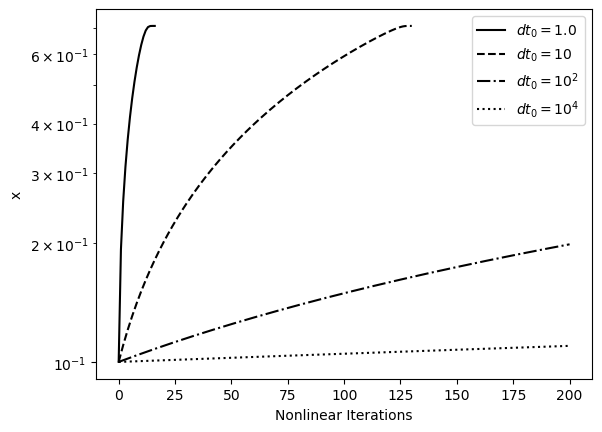

PTC failure; increase maxit and/or dt0
Residual norm =  9.13545e-02
Current values: maxit  =  200,  dt0 = 1.00000e-02
Give the history array a look to see what's happening.
  
PTC failure; increase maxit and/or dt0
Residual norm =  5.35783e-02
Current values: maxit  =  200,  dt0 = 1.00000e-03
Give the history array a look to see what's happening.
  


PyObject Text(0.5, 24.0, 'Nonlinear Iterations')

In [138]:
## Set up the problem
x0=.1
ustable=.5*sqrt(2.0)
uunstable=0.0
## for a few curated values of dt_0
dtlist=[1.0, 1.e1, 1.e2, 1.e4]
## and collect the results.
outdata=[]
for id=1:4
   dti=10.0^(1-id)
   ptcdata1=ptcsolsc(sptest,x0; dt0=dti, rtol=1.e-6, maxit=200)
   push!(outdata,ptcdata1.solhist')
end
## Get some labels for the plots.
labels=[
L"$dt_0 = 1.0$",
L"$dt_0 = 10$",
L"$dt_0 = 10^{2}$",
L"$dt_0 = 10^{4}$"
]
## Make the figure.
plothist(outdata,labels,"solution")


The message so far is that if $dt_0$ is either too small or too large, convergence will suffer and that too small is better than too large. One reason for this is the theoretical result that you will converge to the steady-state solution you want, namely $\vx^* = \lim_{t \to \infty} \vx(t)$ if $dt_0$ is sufficiently small.

If $dt_0$ is too large, the results can be inconsistent. In the example above, the two convergent iterations found the correct steady state solution $x^* = \sqrt{1/2}$. However ...

In [139]:
ptcoutwrong=ptcsolsc(sptest,x0; dt0=3.0);
[ptcoutwrong.solhist' ptcoutwrong.history]

8×2 Array{Float64,2}:
  1.00000e-01  4.90000e-02
 -2.58537e-01  1.11987e-01
 -5.00754e-01  1.24811e-01
 -6.14083e-01  7.54723e-02
 -6.80014e-01  2.55555e-02
 -7.04098e-01  2.98965e-03
 -7.07065e-01  4.17213e-05
 -7.07107e-01  8.13958e-09

That's something to think about, isn't it? Note that the residual norm __increased__ on its way to the wrong steady-state (wrong means that it is not the $\lim_{t \to \infty} x(t)$.

There's one more thing to say about the sptest example. It is a special case ($\lambda = 1/2$) of 
$$
f(x,\lambda) = x^3 - \lambda x.
$$
If we plot __all__ the solutions of $f(x,\lambda) = 0$ we get a __bifurcation diagram__. The solution sets are
the line $x=0$ and the parabola $\lambda = x^2$. Remember that $x=0$ is stable for $\lambda < 0$ and unstable for
$\lambda > 0$. We will label the stable and unstable branches in the diagram. 

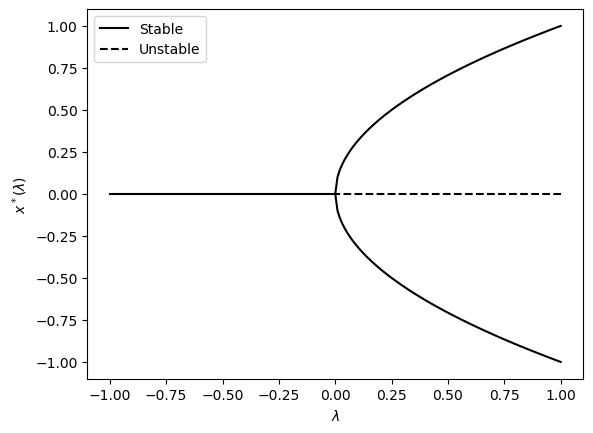

In [140]:
PitchFork1();

Moving from the left you seee that at $\lambda = -$ the stable solutions __bifurcates__ into two stable braches. The implicit function theorem
<cite data-cite="herb"><a href="siamfa.html#herb">(Kel87)</cite>
says that this can only happen if $\partial f(0,0)/\partial x = 0$. This kind of singularity is called, for obvious reasons, a __pitchfork bifucation__
<cite data-cite="govaerts"><a href="siamfa.html#govaerts">(Gov00)</cite>
<cite data-cite="herb"><a href="siamfa.html#herb">(Kel87)</cite>.
We will see a more interesting example in the subsequent chapters.

## Section 1.11 Projects

### Estimating the q-order


One can examine the data in the history vector to estimate the q-order in the following way. 
If $x_n \to x^*$ with q-order $p$, then one might hope that
$$
\| \mf(\vx_{n+1}) \| \approx K \| \mf(\vx_n) \|^p
$$
for some $K > 0$. If that happens, then, as $n \to \infty$,
$$
\log (\| \mf(\vx_{n+1}) \|) \approx p \log(\| \mf(\vx_n) \|)
$$
and so
$$
p \approx \frac{\log (\| \mf(\vx_{n+1}) \|)}{\log(\| \mf(\vx_n) \|)}.
$$
Hence, by looking at the history array, we can estimate $p$.

Here are a few examples for Newton's method. We'll look at $f(x) = cos(x)-x$ from the MyFunction module and $f(x) = atan(x)$  and examine the logs of the residuals.


In [141]:
myfunout=nsolsc(myfun,0.1)
loghist=log.(myfunout.history)
nn=length(loghist)
qest=loghist[2:nn]./loghist[1:nn-1]

4-element Array{Float64,1}:
 1.07643e+01
 3.91318e+00
 2.43526e+00
 2.17677e+00

This is pretty good. Since the iteration should be quadratically convergent, we would expect the sequence to converge to 2. We are not aiming for high-precision results here and should be happy.

And now for $f(x)=atan(x)$ ...

In [142]:
tanout=nsolsc(atan,1.0)
loghist=log.(tanout.history)
nn=length(loghist)
qest=loghist[2:nn]./loghist[1:nn-1]

4-element Array{Float64,1}:
 2.71765e+00
 3.27699e+00
 3.18343e+00
 3.05923e+00

Wait a minute! What happened to the q-order of 2? In fact, the q-order for this problem is 3! Can you figure out why?

Your job is to ...

- Apply this idea for the Newton, Shamanskii, secant, and chord methods for the example problems in this chapter.
- Try it for $\sin(x) = 0$ with an initial iterate of $x_0 = 3$. 

Are the estimated q-orders
consistent with the theory? Can you explain the q-orders that
you observe. 

### Singular Problems

Solve $f(x) = x^2 = 0$ with Newton's method, the chord method,
and the secant method.
Try the alternative iteration
$$
x_{n+1} = x_n - 2 f'(x_n)^{-1} f(x_n).
$$
Look at the history vectors from the two cases. Can you explain your observations?

### Non-Lipschitz derivative

Solve $f(x) = 0$ where $f(x) = x + |x|^{3/2}$ with Newton's method. Do you see q-superlinear convergence? Explain your results and then look at
<cite data-cite="herbholder"><a href="siamfa.html#herbholder">(Kel70)</cite>
to see if you got it right.

## Next notebook = [Chapter 2: Finding the Newton Step with Gaussian Elimination](SIAMFANLCh2.ipynb)